In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifetimes

%matplotlib inline

Read data file

In [2]:
transactions_df = pd.read_csv('data.csv',encoding='ISO-8859-1')

In [3]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Drop Transactions with missing customer IDs

In [4]:
transactions_df = transactions_df[transactions_df['CustomerID'].notnull()].copy()

Convert Invoice Date column from a string column to a datetime column

In [5]:
transactions_df['InvoiceDate'] = pd.to_datetime(transactions_df['InvoiceDate'])

In [6]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [7]:
transactions_df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Drop transactions with negative quantities

In [8]:
transactions_df = transactions_df[transactions_df['Quantity'] > 0]

In [9]:
transactions_df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,397924.000000,397924.000000
mean,13.021823,3.116174
std,180.420210,22.096788
min,1.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Get the most recent transaction made by a customer in the dataset

In [10]:
most_recent_transaction = transactions_df['InvoiceDate'].max()

In [11]:
most_recent_transaction

Timestamp('2011-12-09 12:50:00')

Create a dataframe containing the number of days elasped since the most recent transaction for each user

In [12]:
# Compute the lastest transaction for each user
latest_transactions_per_user = transactions_df.groupby('CustomerID')['InvoiceDate'].max()

recency_df = latest_transactions_per_user.reset_index()
recency_df['recency'] = recency_df['InvoiceDate'].apply(lambda date: (most_recent_transaction - date).days)

In [13]:
recency_df.head()

,CustomerID,InvoiceDate,recency
0,12346.0,2011-01-18 10:01:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


Create a dataframe containing the number of transactions made for each user

In [14]:
# Calculate the number of invididual invoices generated for each customer
num_transactions_per_user = transactions_df.groupby('CustomerID')['InvoiceNo'].unique().apply(lambda lst: len(lst))

frequency_df = num_transactions_per_user.reset_index().rename(columns={'InvoiceNo':'frequency'})

In [15]:
frequency_df

,CustomerID,frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1
...,...,...
4334,18280.0,1
4335,18281.0,1
4336,18282.0,2
4337,18283.0,16


Calculate the age of the customer

In [16]:
first_transactions = transactions_df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_transactions['age'] = first_transactions['InvoiceDate'].apply(lambda date: (most_recent_transaction - date).days)

In [17]:
recency_frequency_df = pd.merge(pd.merge(recency_df, frequency_df, on='CustomerID').drop('InvoiceDate',axis=1), 
                                first_transactions, on='CustomerID').drop('InvoiceDate', axis=1)

In [18]:
recency_frequency_df

,CustomerID,recency,frequency,age
0,12346.0,325,1,325
1,12347.0,1,7,366
2,12348.0,74,4,357
3,12349.0,18,1,18
4,12350.0,309,1,309
...,...,...,...,...
4334,18280.0,277,1,277
4335,18281.0,180,1,180
4336,18282.0,7,2,125
4337,18283.0,3,16,336


Fit Pareto/NDB Model

In [19]:
mdl = lifetimes.ParetoNBDFitter()

In [20]:
mdl.fit(recency_frequency_df['frequency'], recency_frequency_df['recency'], recency_frequency_df['age'])

C:\Users\jerem\anaconda3\lib\site-packages\scipy\optimize\_optimize.py:811: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


<lifetimes.ParetoNBDFitter: fitted with 4339 subjects, alpha: 2.03, beta: 386.00, r: 1.39, s: 1.25>

In [21]:
recency_frequency_df['probability_alive'] = mdl.conditional_probability_alive(recency_frequency_df['frequency'],
                                                                              recency_frequency_df['recency'],
                                                                              recency_frequency_df['age'])

C:\Users\jerem\anaconda3\lib\site-packages\scipy\special\_logsumexp.py:108: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)
C:\Users\jerem\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [22]:
recency_frequency_df

,CustomerID,recency,frequency,age,probability_alive
0,12346.0,325,1,325,1.000000e+00
1,12347.0,1,7,366,1.049304e-15
2,12348.0,74,4,357,2.948637e-03
3,12349.0,18,1,18,1.000000e+00
4,12350.0,309,1,309,1.000000e+00
...,...,...,...,...,...
4334,18280.0,277,1,277,1.000000e+00
4335,18281.0,180,1,180,1.000000e+00
4336,18282.0,7,2,125,7.788878e-03
4337,18283.0,3,16,336,7.671161e-30


Create Conditional Probability Alive Plot

In [23]:
from lifetimes.plotting import plot_probability_alive_matrix

C:\Users\jerem\anaconda3\lib\site-packages\scipy\special\_logsumexp.py:108: RuntimeWarning: overflow encountered in exp
  tmp = b * np.exp(a - a_max)
C:\Users\jerem\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

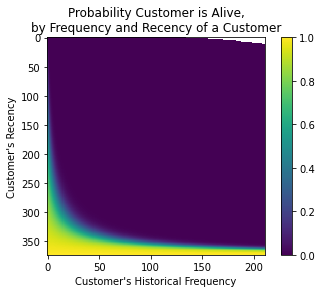

In [24]:
plot_probability_alive_matrix(mdl)

Calculated expected transactions 20 days into the future

In [25]:
recency_frequency_df['predicted_transactions'] = mdl.conditional_expected_number_of_purchases_up_to_time(20,recency_frequency_df['frequency'],
                                                                                                         recency_frequency_df['recency'],
                                                                                                         recency_frequency_df['age'])

C:\Users\jerem\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in logaddexp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
recency_frequency_df

,CustomerID,recency,frequency,age,probability_alive,predicted_transactions
0,12346.0,325,1,325,1.000000e+00,1.438561e-01
1,12347.0,1,7,366,1.049304e-15,4.707988e-16
2,12348.0,74,4,357,2.948637e-03,8.712711e-04
3,12349.0,18,1,18,1.000000e+00,2.318387e+00
4,12350.0,309,1,309,1.000000e+00,1.511963e-01
...,...,...,...,...,...,...
4334,18280.0,277,1,277,1.000000e+00,1.683929e-01
4335,18281.0,180,1,180,1.000000e+00,2.573132e-01
4336,18282.0,7,2,125,7.788878e-03,4.062349e-03
4337,18283.0,3,16,336,7.671161e-30,7.760143e-30
